In [4]:
#import neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.model_selection import train_test_split


In [ ]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

170498071/170498071 [==============================] - 2s 0us/step


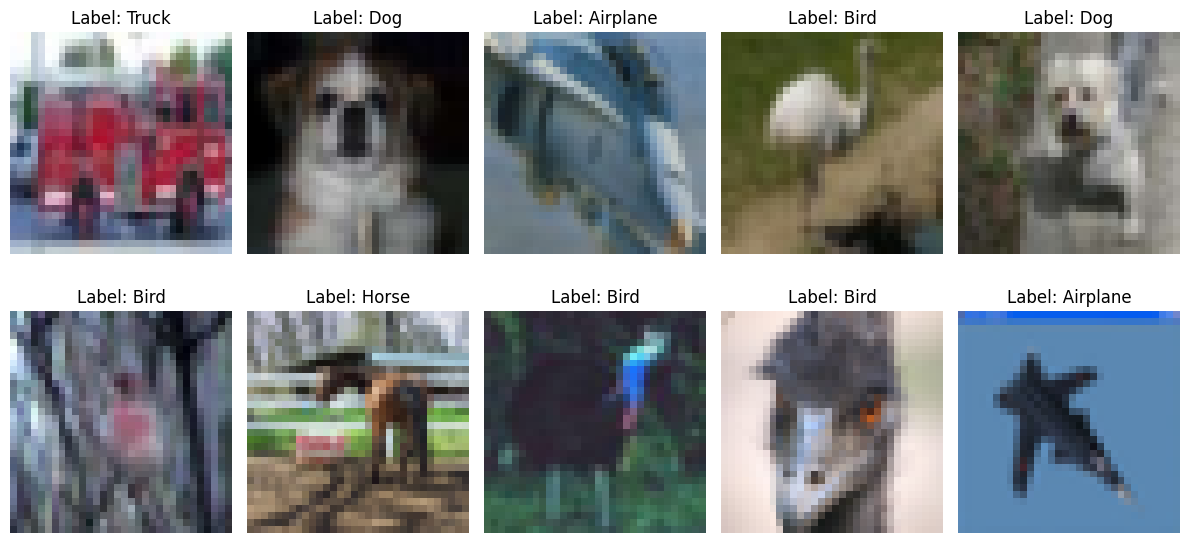

In [ ]:
# Assuming you have class_names defined as a list
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

# Display 10 random images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    # Generate a random index
    random_index = np.random.randint(0, len(train_images))

    # Display the image
    axes[i].imshow(train_images[random_index])
    axes[i].axis('off')

    # Use the original label without one-hot encoding to get the class name
    label_index = int(train_labels[random_index][0])  # Assuming one-hot encoding with a single class
    class_name = class_names[label_index]

    axes[i].set_title(f'Label: {class_name}')

plt.tight_layout()
plt.show()

In [ ]:
# One-hot encode the labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
print("Shape of train_labels after one-hot encoding:", train_labels.shape)
print("Shape of test_labels after one-hot encoding:", test_labels.shape)


Shape of train_labels after one-hot encoding: (50000, 10)
Shape of test_labels after one-hot encoding: (10000, 10)


In [ ]:
### # Resize images to match reshaped pretrained model input size (96, 96)
# Function to resize and preprocess images
def resize_and_preprocess(images, labels, target_size=(96, 96)):
    resized_images = np.array([img_to_array(array_to_img(img).resize(target_size)) for img in images])
    preprocessed_images = preprocess_input(resized_images)
    return preprocessed_images, labels

# Generator for training data with augmentation
def training_data_generator(images, labels, batch_size=64):
    while True:
        for i in range(0, len(images), batch_size):
            batch_images, batch_labels = images[i:i+batch_size], labels[i:i+batch_size]
            batch_images, batch_labels = resize_and_preprocess(batch_images, batch_labels)
            yield datagen.flow(batch_images, batch_labels, batch_size=batch_size).next()

# Resize and preprocess the test data
test_images, test_labels = resize_and_preprocess(test_images, test_labels)

# Resize and preprocess the training data
train_images, train_labels = resize_and_preprocess(train_images, train_labels)

In [ ]:
print("train image shape", train_images.shape)
print("train labels shape", test_labels.shape)

train image shape (50000, 96, 96, 3)
train labels shape (10000, 10)


In [5]:
### Build the model from scratch
# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  #dropout for regularization

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # dropout for regularization

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # dropout for regularization

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) #dropout for regularization
model.add(Dense(10, activation='softmax'))
# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 64)        0

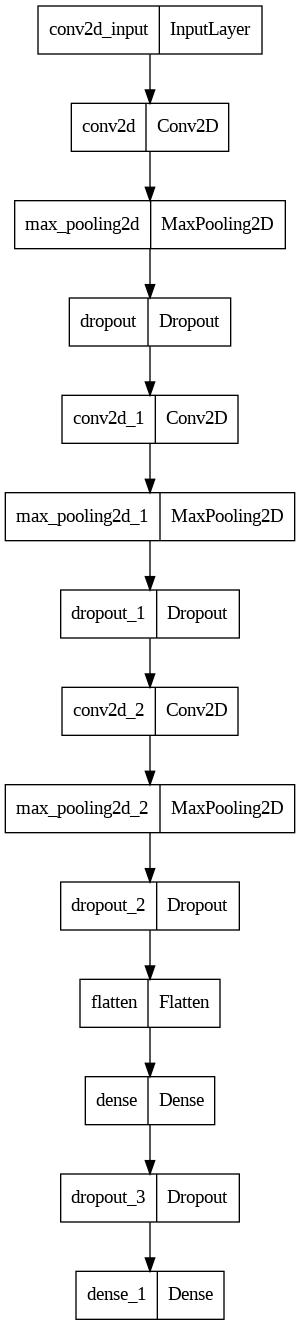

In [ ]:
plot_model(model)

In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_scratch= model.fit(train_images, train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(test_images, test_labels),
                    verbose=1)

Epoch 1/20
1563/1563 [==============================] - 98s 62ms/step - loss: 1.8461 - accuracy: 0.3326 - val_loss: 1.5670 - val_accuracy: 0.4640
Epoch 2/20
1563/1563 [==============================] - 93s 59ms/step - loss: 1.5351 - accuracy: 0.4519 - val_loss: 1.3703 - val_accuracy: 0.5406
Epoch 3/20
1563/1563 [==============================] - 99s 63ms/step - loss: 1.3948 - accuracy: 0.5031 - val_loss: 1.2816 - val_accuracy: 0.5609
Epoch 4/20
1563/1563 [==============================] - 95s 61ms/step - loss: 1.2969 - accuracy: 0.5407 - val_loss: 1.1810 - val_accuracy: 0.5986
Epoch 5/20
1563/1563 [==============================] - 93s 60ms/step - loss: 1.2177 - accuracy: 0.5684 - val_loss: 1.1059 - val_accuracy: 0.6196
Epoch 6/20
1563/1563 [==============================] - 97s 62ms/step - loss: 1.1512 - accuracy: 0.5966 - val_loss: 1.0252 - val_accuracy: 0.6470
Epoch 7/20
1563/1563 [==============================] - 101s 64ms/step - loss: 1.0897 - accuracy: 0.6179 - val_loss: 0.9978 

In [ ]:
#model eVALUATION
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)


313/313 - 4s - loss: 0.7925 - accuracy: 0.7246 - 4s/epoch - 13ms/step

Test accuracy: 0.7246000170707703


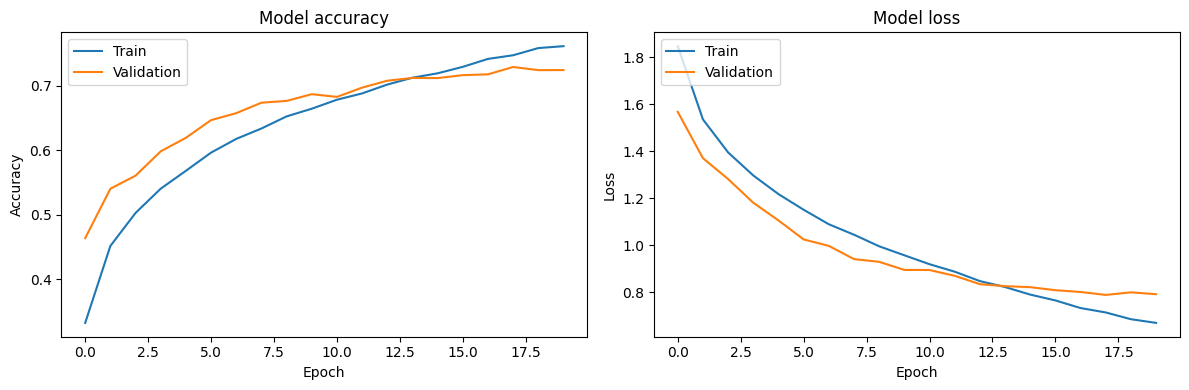

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_scratch.history['accuracy'])
plt.plot(history_scratch.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_scratch.history['loss'])
plt.plot(history_scratch.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
### Build a model using pretrained model: MobileNetV2
# Load MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
# freeze the first 10 layers of the base model
for layer in base_model.layers[10:]:
    layer.trainable=True

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
### Create inputs with correct shape and model on top of the pretrained base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

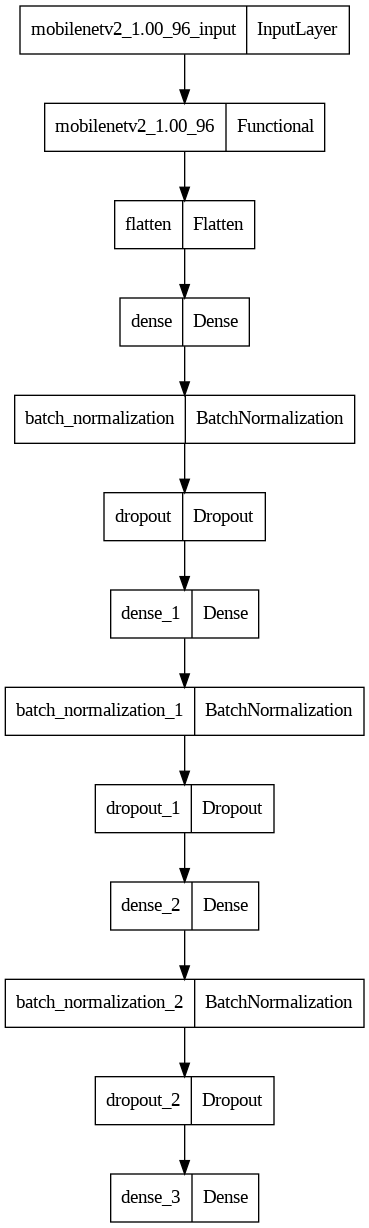

In [ ]:
plot_model(model)

In [ ]:
from keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.0001  # Initial learning rate
    decay_factor = 0.5   # Factor by which the learning rate will decay
    decay_epochs = 5     # Number of epochs after which to apply decay

    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)
#Define epoch and batch_size
epochs = 20
batch_size = 64

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit the pretrained the model using image generator
History_pretrained = model.fit(
    training_data_generator(train_images, train_labels, batch_size=64),
    epochs=epochs,
    steps_per_epoch=len(train_images) // batch_size,
    validation_data=(test_images, test_labels),
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/20
781/781 [==============================] - 309s 376ms/step - loss: 1.3788 - accuracy: 0.5781 - val_loss: 0.5137 - val_accuracy: 0.8378 - lr: 1.0000e-04
Epoch 2/20
781/781 [==============================] - 292s 374ms/step - loss: 0.6440 - accuracy: 0.8061 - val_loss: 0.4295 - val_accuracy: 0.8676 - lr: 1.0000e-04
Epoch 3/20
781/781 [==============================] - 285s 365ms/step - loss: 0.4950 - accuracy: 0.8541 - val_loss: 0.2803 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 4/20
781/781 [==============================] - 290s 371ms/step - loss: 0.4211 - accuracy: 0.8738 - val_loss: 0.2381 - val_accuracy: 0.9228 - lr: 1.0000e-04
Epoch 5/20
781/781 [==============================] - 286s 366ms/step - loss: 0.3682 - accuracy: 0.8865 - val_loss: 0.2493 - val_accuracy: 0.9200 - lr: 1.0000e-04
Epoch 6/20
781/781 [==============================] - 284s 364ms/step - loss: 0.3093 - accuracy: 0.9074 - val_loss: 0.1861 - val_accuracy: 0.9404 - lr: 5.0000e-05
Epoch 7/20
781/781 [==

In [ ]:
# Evaluation of pretrained model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 11s - loss: 0.1621 - accuracy: 0.9560 - 11s/epoch - 35ms/step

Test accuracy: 0.9559999704360962


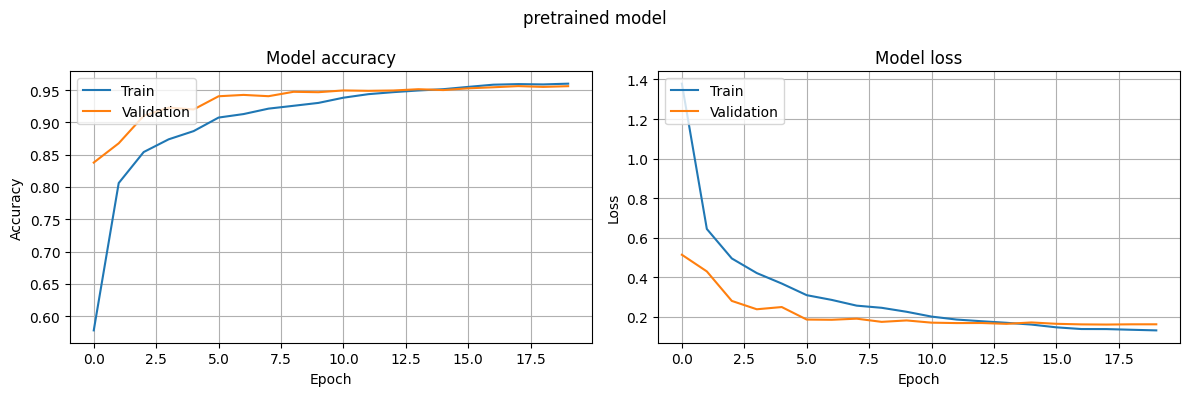

In [ ]:

# Plot training history
plt.figure(figsize=(12, 4))

# Set global title
plt.suptitle('pretrained model')

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(History_pretrained.history['accuracy'])
plt.plot(History_pretrained.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(History_pretrained.history['loss'])
plt.plot(History_pretrained.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

313/313 [==============================] - 12s 39ms/step
Confusion Matrix:
[[966   1   4   1   1   0   0   2  19   6]
 [  2 966   0   0   0   0   0   0   0  32]
 [  9   0 945   9  14   6  10   5   1   1]
 [  2   1   9 893  15  58  12   4   4   2]
 [  1   1   8  10 957   7   5  10   1   0]
 [  0   1   4  43  10 928   4   7   1   2]
 [  3   1   5   8   0   2 980   1   0   0]
 [  4   1   0   3  11   9   1 971   0   0]
 [ 13   4   1   0   0   0   1   0 973   8]
 [  1  14   0   0   0   0   0   1   3 981]]
Classification Report:
              precision    recall  f1-score   support

    Airplane       0.97      0.97      0.97      1000
  Automobile       0.98      0.97      0.97      1000
        Bird       0.97      0.94      0.96      1000
         Cat       0.92      0.89      0.91      1000
        Deer       0.95      0.96      0.95      1000
         Dog       0.92      0.93      0.92      1000
        Frog       0.97      0.98      0.97      1000
       Horse       0.97      0.97     

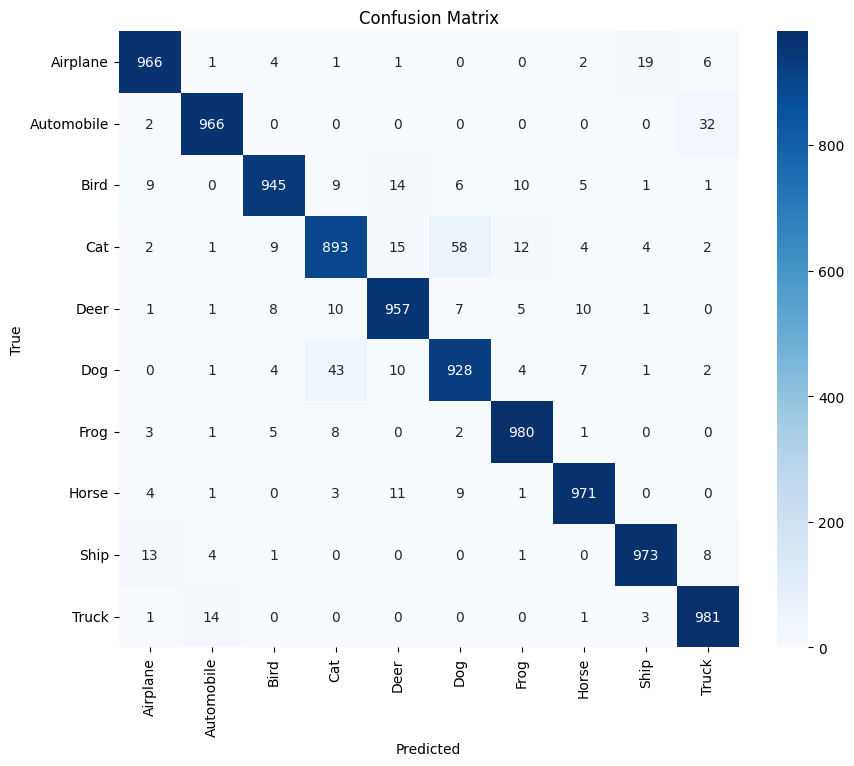

In [ ]:
### Generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
predictions = model.predict(test_images)

# Convert one-hot encoded labels back to categorical labels
test_labels_categorical = np.argmax(test_labels, axis=1)
predictions_categorical = np.argmax(predictions, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_categorical, predictions_categorical)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(test_labels_categorical, predictions_categorical, target_names=class_names)
print("Classification Report:")
print(class_report)

# Plot the confusion matrix with labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()